In [51]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import Angle
from photutils.aperture import RectangularAperture
from photutils.aperture import aperture_photometry
from pathlib import Path
import re
import pandas as pd
# test file
fn = '/Users/thomasmcintosh/Desktop/CHARIS-REU/Cubes/cubes/internal-cal/CRSA00165896_cube.fits'

In [2]:
# finding rectangle params

# rectangle bounds (found by eye in ds9)

topleft_lbeam = np.array([13,130])
bottomleft_lbeam = np.array([72,12])
bottomright_lbeam = np.array([133,43])
topright_lbeam = np.array([69,160])
topleft_rbeam = np.array([71,160])
topright_rbeam = np.array([130,190])
bottomright_rbeam = np.array([190,71])
bottomleft_rbeam = np.array([135,44])

# calculate width, height, center, and rotation of rectangle

width_lbeam = np.linalg.norm(bottomleft_lbeam - bottomright_lbeam)
width_rbeam = np.linalg.norm(bottomleft_rbeam - bottomright_rbeam)
# note - different widths
height_lbeam = np.linalg.norm(topleft_lbeam - bottomleft_lbeam)
height_rbeam = np.linalg.norm(topleft_rbeam - bottomleft_rbeam)
# averaging heights for greater accuracy
height = (height_lbeam + height_rbeam) / 2
# heights similar to eyeballed values
centroid_lbeam = (topleft_lbeam + bottomleft_lbeam + bottomright_lbeam + topright_lbeam) / 4
centroid_rbeam = (topleft_rbeam + bottomleft_rbeam + bottomright_rbeam + topright_rbeam) / 4
# centroids are similar to eyeballed values
theta_lbeam = np.arctan2(bottomright_lbeam[1] - bottomleft_lbeam[1], bottomright_lbeam[0] - bottomleft_lbeam[0])
theta_rbeam = np.arctan2(bottomright_rbeam[1] - bottomleft_rbeam[1], bottomright_rbeam[0] - bottomleft_rbeam[0])

# average theta values for greater accuracy
theta = (theta_lbeam + theta_rbeam) / 2 # degrees are defined as positive=ccw

# shrink height by 10% to avoid edge effects

shrunkheight = height * 0.85

# shrink widths to avoid edge defect and correct imperfect rectangles

shrunkwidth_lbeam = width_lbeam * 0.65

print(theta)






0.46326596610192305


In [3]:
# 2 equal rectangular apertures, use left beam width

aperture_lbeam = RectangularAperture(centroid_lbeam, shrunkwidth_lbeam, shrunkheight, theta=theta)
aperture_rbeam = RectangularAperture(centroid_rbeam, shrunkwidth_lbeam, shrunkheight, theta=theta)



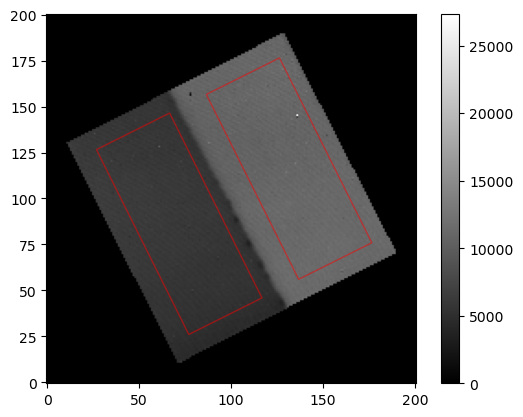

(22, 201, 201)

In [110]:
# visualize apertures 
fn_2 = '/Users/thomasmcintosh/Desktop/CHARIS-REU/Cubes_2/cubes/CRSA00162889_cube.fits'
test_hdul = fits.open(fn_2)
test_image_data = test_hdul[1].data
aperture_lbeam.plot(color='red', alpha=0.5)
aperture_rbeam.plot(color='red', alpha=0.5)
plt.imshow(test_image_data[8], origin='lower', cmap='gray')
plt.colorbar()
plt.show()
test_image_data.shape

In [15]:
# test aperture photometry

phot_lbeam = aperture_photometry(test_image_data[0], aperture_lbeam)
phot_rbeam = aperture_photometry(test_image_data[0], aperture_rbeam)

# calculate norm single differences between left and right beam photometry

test_single_diff = (phot_rbeam['aperture_sum'] - phot_lbeam['aperture_sum'])/ (phot_rbeam['aperture_sum'] + phot_lbeam['aperture_sum'])
print(f"Test single difference: {test_single_diff}")
print(phot_rbeam['aperture_sum'] + phot_lbeam['aperture_sum'])




Test single difference:    aperture_sum   
------------------
0.2339440675816592
   aperture_sum  
-----------------
2135783.734734986


In [26]:
# normalized single difference and sum functions

def single_sum_and_diff(fits_cube_path, wavelength_bin):
    """Calculate normalized single difference and sum between left and right beam 
    rectangular aperture photometry from a CHARIS fits cube.
    
    Parameters:
    -----------
    fits_cube_path : str or Path
        Path to the CHARIS fits cube file.
        
    wavelength_bin : int
        Index of the wavelength bin to analyze (0-based).
    
    Returns:
    --------
    np.ndarray
        Array with two elements:
            [0] single_sum : float
                Single sum of left and right beam apertures:
                (R + L)
            [1] norm_single_diff : float
                Normalized single difference of left and right beam apertures:
                (R - L) / (R + L)
    """
    
    # check if fits_cube_path is a valid file path

    fits_cube_path = Path(fits_cube_path)
    if not fits_cube_path.is_file():
        raise FileNotFoundError(f"File not found: {fits_cube_path}")
    
    # retrieve fits cube data

    hdul = fits.open(fits_cube_path)
    cube_data = hdul[1].data

    # check if data is a 3d cube (wavelength, x, y)

    if cube_data.ndim != 3:
        raise ValueError("Input data must be a 3D cube (wavelength, x, y).")
        
    # check if wavelength_bin is within bounds

    if not (0 <= wavelength_bin < cube_data.shape[0]):
        raise ValueError(f"wavelength_bin must be between 0 and {cube_data.shape[0] - 1}.")
    
    image_data = cube_data[wavelength_bin]

    # define rectangular apertures for left and right beams
    # note- these values are based on rough analysis and may need adjustment for high precision

    centroid_lbeam = [71.75, 86.25] 
    centroid_rbeam = [131.5, 116.25]
    aperture_width = 44.47634202584561
    aperture_height = 112.3750880855165
    theta = 0.46326596610192305

    # define apertures perform aperture photometry 

    aperture_lbeam = RectangularAperture(centroid_lbeam, aperture_width, aperture_height, theta=theta)
    aperture_rbeam = RectangularAperture(centroid_rbeam, aperture_width, aperture_height, theta=theta)
    phot_lbeam = aperture_photometry(image_data, aperture_lbeam)
    phot_rbeam = aperture_photometry(image_data, aperture_rbeam)

    # calculate normalized single difference and sum
    single_sum = phot_rbeam['aperture_sum'][0] + phot_lbeam['aperture_sum'][0]
    norm_single_diff = (phot_rbeam['aperture_sum'][0] - phot_lbeam['aperture_sum'][0]) / single_sum
    return np.array([single_sum, norm_single_diff])
    
single_sum_and_diff(fn, 0)  



array([2.13578373e+06, 2.33944068e-01])

In [115]:
# function to write relevant fits info to a csv

def write_fits_info_to_csv(cube_directory_path, raw_cube_path, output_csv_path, wavelength_bin):
    """Write filepath, D_IMRANG (derotator angle), RET-ANG1 (HWP angle), 
    single sum, single difference, and wavelength values for a wavelength bin from each fits cube in the directory.

    FITS parameters are extracted from raw files, while single sum and difference are calculated using the
    fits cube data and the defined rectangular apertures.
    If the necessary header keywords are not present, the values will be set to NaN.

    Note - This function assumes that the raw and extracted cubes have the same number in the filepath. If
    you processed your cubes in the CHARIS DPP, this is not the case. 
    
    Parameters:
    -----------
    fits_directory_path : str or Path
        Path to the directory containing CHARIS fits cubes.
        
    raw_cube_path : str or Path
        Path to the directory containing the matching raw CHARIS FITS files.

    output_csv_path : str or Path
        Path where the output csv will be created.

    wavelength_bin : int
        Index of the wavelength bin to analyze (0-based).

    Returns:
    --------
    None
    """
    # check for valid file paths

    cube_directory_path = Path(cube_directory_path)
    raw_cube_path = Path(raw_cube_path)
    output_csv_path = Path(output_csv_path)

    if not cube_directory_path.is_dir():
        raise NotADirectoryError(f"Directory not found: {cube_directory_path}")
    if output_csv_path.suffix != '.csv':
        raise ValueError(f"Output path must be a CSV file, got {output_csv_path}")
    if not raw_cube_path.is_dir():
        raise NotADirectoryError(f"Raw cube directory does not exist: {raw_cube_path}")
    if wavelength_bin > 21:
        raise ValueError(f"This function is currently only compatible with lowres mode, with 22 wavelength bins.")
    # prepare output csv file

    output_csv_path = Path(output_csv_path)
    with open(output_csv_path, 'w') as f:
        f.write("filepath,D_IMRANG,RET-ANG1,single_sum,norm_single_diff,wavelength_bin\n")

        # iterate over all fits files in the directory

        for fits_file in sorted(cube_directory_path.glob('*.fits')):
            try:

                # check if corresponding raw fits file exists
                 
                match = re.search(r"(\d{8})", fits_file.name)
                if not match:
                    raise ValueError(f"Could not extract 8-digit ID from filename {fits_file.name}")
                fits_id = match.group(1)
                raw_candidates = list(raw_cube_path.glob(f"*{fits_id}*.fits"))
                if not raw_candidates:
                    raise FileNotFoundError(f"No raw FITS file found for ID {fits_id}")
                raw_fits = raw_candidates[0]
                
                with fits.open(raw_fits) as hdul_raw:
                    raw_header = hdul_raw[0].header
                    d_imrang = raw_header.get("D_IMRANG", np.nan)
                    ret_ang1 = raw_header.get("RET-ANG1", np.nan)

              

                # calculate single sum and normalized single difference

                single_sum,norm_single_diff = single_sum_and_diff(fits_file, wavelength_bin)

                # wavelength bins for lowres mode

                bins = np.array([1159.5614, 1199.6971, 1241.2219, 1284.184 , 1328.6331, 1374.6208,
                1422.2002, 1471.4264, 1522.3565, 1575.0495, 1629.5663, 1685.9701,
                1744.3261, 1804.7021, 1867.1678, 1931.7956, 1998.6603, 2067.8395,
                2139.4131, 2213.4641, 2290.0781, 2369.3441])
                
                # write to csv file

                f.write(f"{fits_file},{d_imrang},{ret_ang1},{single_sum},{norm_single_diff},{bins[wavelength_bin]}\n")
            except Exception as e:
                print(f"Error processing {fits_file}: {e}")
    print(f"CSV file written to {output_csv_path}")


)

CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Cubes/cubes/internal-cal/charis_internal_calbin0.csv


In [95]:
def plot_single_differences(csv_file_path, plot_save_path=None):
    """Plot norm single differences as a function of the HWP angle for one 
    wavelength bin from a CSV containing headers "D_IMRANG" , "RET-ANG1" , 
    "norm_single_diff", and "wavelength_bin".
    This can be obtained from the write_fits_info_to_csv function.

    Parameters:
    -----------
    csv_file_path : str or Path
        Path to the specified CSV file.

    plot_save_path : str or Path, optional
        If provided, the plot will be saved to this path. Must end with '.png'.

    Returns: 
    --------
    None
    """
    # check if csv_file_path is a valid file path

    csv_file_path = Path(csv_file_path)
    if not csv_file_path.is_file():
        raise FileNotFoundError(f"File not found: {csv_file_path}")
    
    # read csv file into pandas dataframe

    df = pd.read_csv(csv_file_path)

    # check if necessary columns are present

    required_columns = ['D_IMRANG', 'RET-ANG1', 'norm_single_diff', 'wavelength_bin']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' is missing from the CSV file.")
        
    # check for multiple wavelength bins
    unique_bins = df['wavelength_bin'].unique()
    if len(unique_bins) > 1:
        raise ValueError("CSV file contains multiple wavelength bins. Please filter to a single bin before plotting.")
    
    # extract data for plotting

    hwp_angles = df['RET-ANG1'].values
    single_diffs = df['norm_single_diff'].values
    wavelength_bin = df['wavelength_bin'].values[0]
    derotator_angles = df['D_IMRANG'].values

    # plot single differences as a function of HWP angle for each derotator angle

    fig, ax = plt.subplots(figsize=(10, 6))
    
    for derotator_angle in np.unique(derotator_angles):
        mask = derotator_angles == derotator_angle
        ax.plot(hwp_angles[mask], single_diffs[mask], marker='o', label=f'{derotator_angle}°')
    ax.set_xlabel('HWP Angle (degrees)')
    ax.set_ylabel('Normalized Single Difference')
    ax.set_title(f'Single Differences vs HWP Angle at {wavelength_bin} nm')
    ax.legend(loc='lower right', fontsize='small', title= r'IMR $\theta$')
    ax.grid()
    plt.show()

    # save plot if a path is provided

    if plot_save_path:
        plot_save_path = Path(plot_save_path)
        if not plot_save_path.parent.is_dir():
            raise NotADirectoryError(f"Directory does not exist: {plot_save_path.parent}")
        if not plot_save_path.suffix == '.png':
            raise ValueError("Plot save path must end with '.png'.")
        fig.savefig(plot_save_path)
        print(f"Plot saved to {plot_save_path}")








In [91]:
def fix_hwp_angles(csv_file_path, nderotator=8):
    '''Take corrupted HWP angles and replace them with assumed values
    in a new csv titled {old_title}_fixed.

    Parameters:
    -----------
    csv_file_path : str or Path
        Path to the specified CSV file containing the corrupted HWP angles.
    
    nderotator : int
        Number of derotator angles (assumed to be 8).
    Returns:
    --------
    None
    '''
    # check if csv_file_path is a valid file path

    csv_file_path = Path(csv_file_path)
    if not csv_file_path.is_file():
        raise FileNotFoundError(f"File not found: {csv_file_path}")
    
    # read csv file into pandas dataframe

    df = pd.read_csv(csv_file_path)

    # check if 'RET-ANG1' column is present

    if 'RET-ANG1' not in df.columns:
        raise ValueError("Column 'RET-ANG1' is missing from the CSV file.")
    
    hwp_angles = np.linspace(0, 90, 9) # define assumed HWP angles
    hwp_angles_assumed = np.tile(hwp_angles, nderotator)  # repeat for n derotator angles

    # save to new csv file with '_fixed' suffix

    fixed_csv_path = csv_file_path.with_name(csv_file_path.stem + '_fixed.csv')
    df.to_csv(fixed_csv_path, index=False)

    print(f"Fixed HWP angles saved to {fixed_csv_path}")

    

# example usage
fix_hwp_angles('/Users/thomasmcintosh/Desktop/CHARIS-REU/charis_cube_info_bin12.csv', nderotator=8)
    








Fixed HWP angles saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/charis_cube_info_bin12_fixed.csv


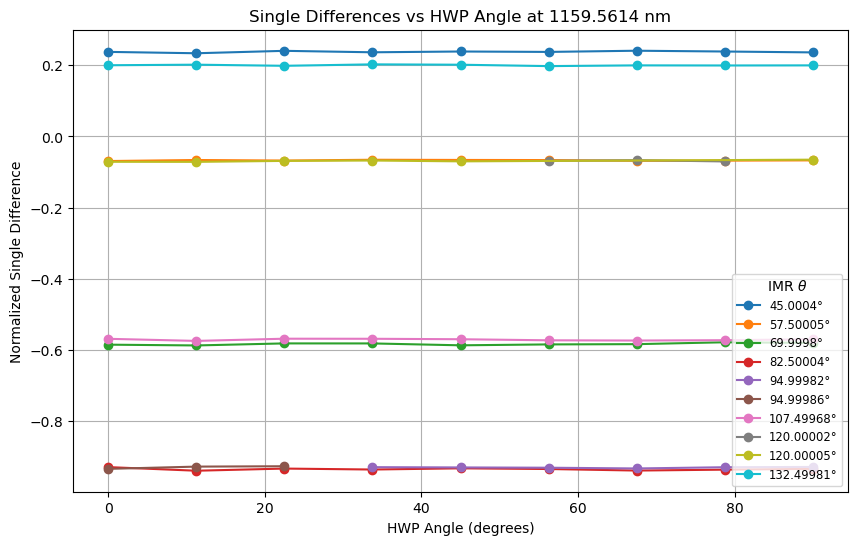

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization/plots/diffvshwp_bin0.png


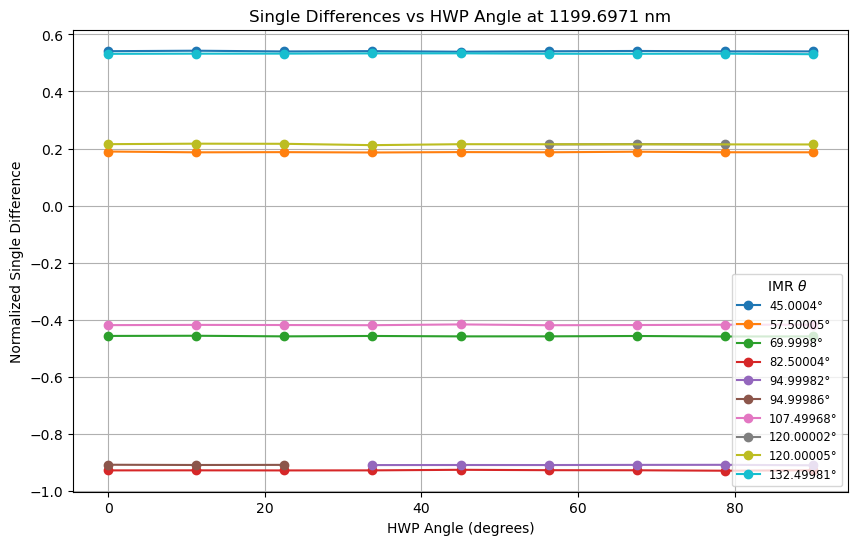

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization/plots/diffvshwp_bin1.png


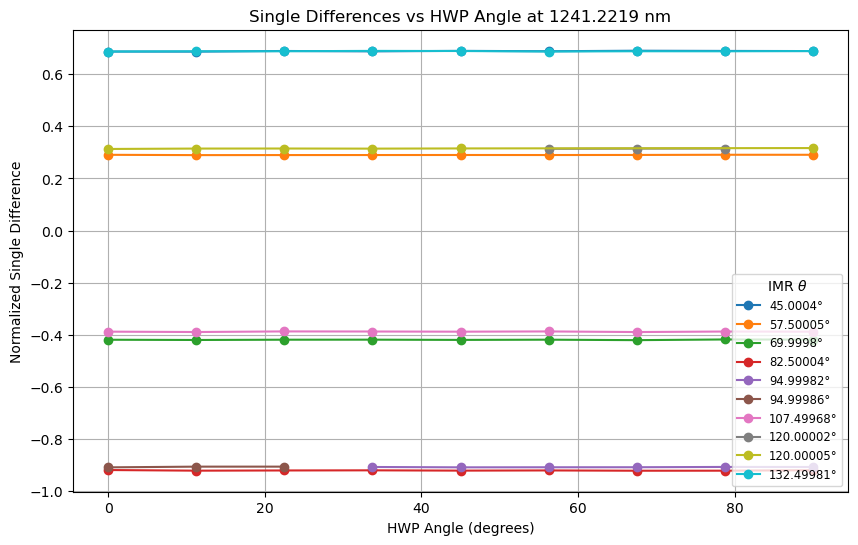

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization/plots/diffvshwp_bin2.png


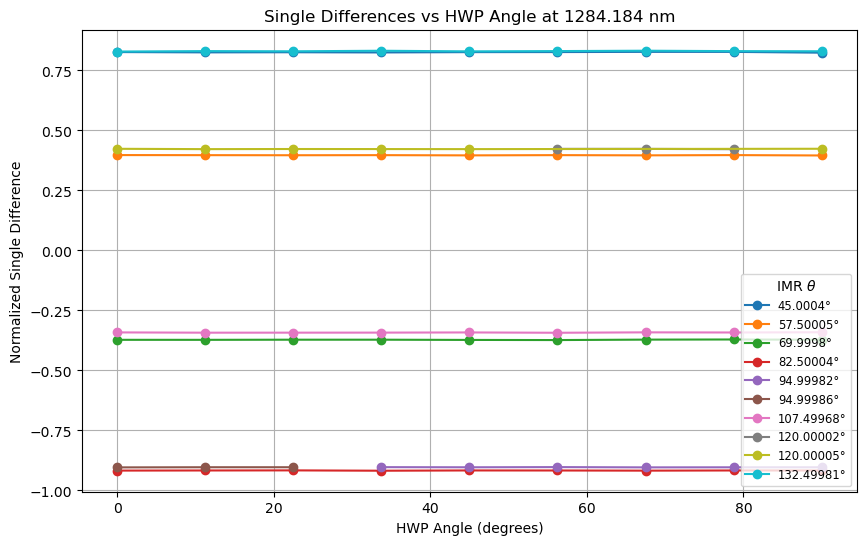

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization/plots/diffvshwp_bin3.png


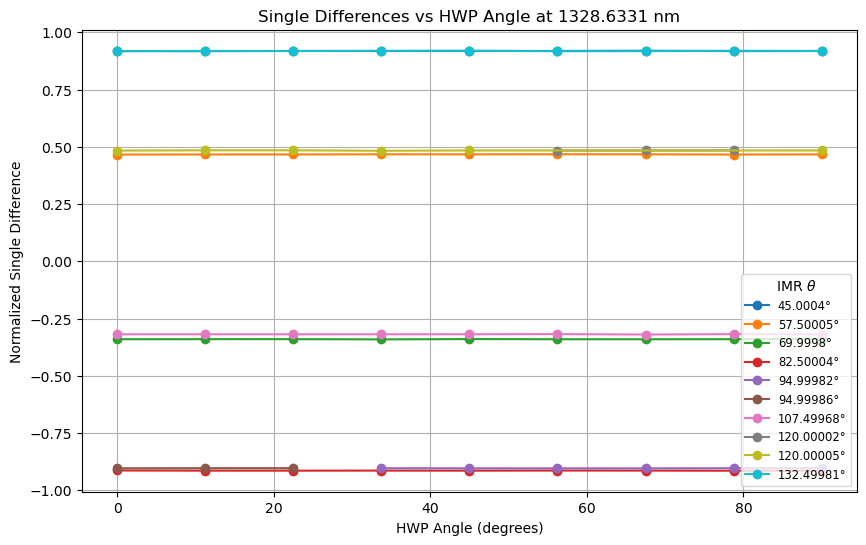

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization/plots/diffvshwp_bin4.png


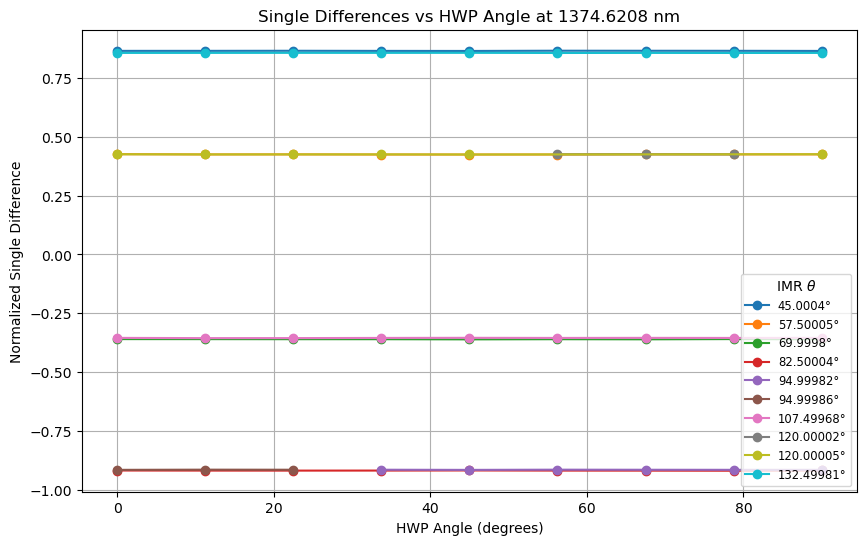

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization/plots/diffvshwp_bin5.png


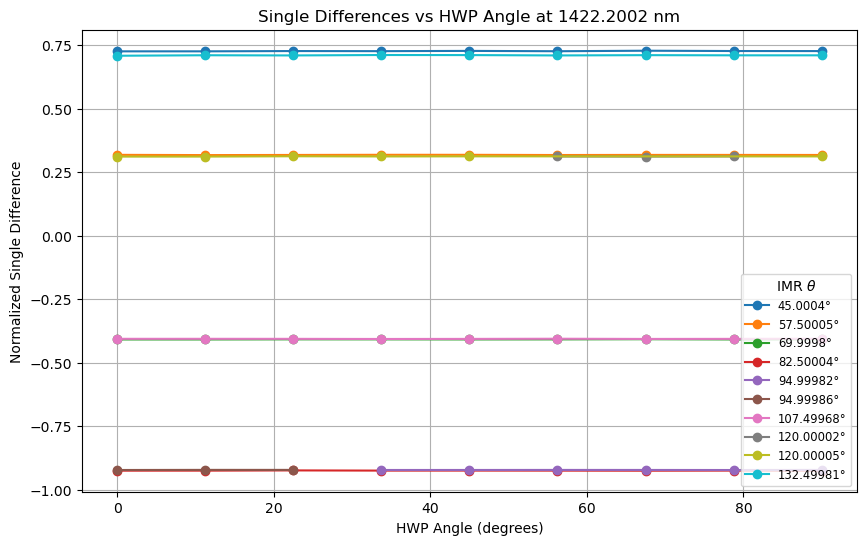

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization/plots/diffvshwp_bin6.png


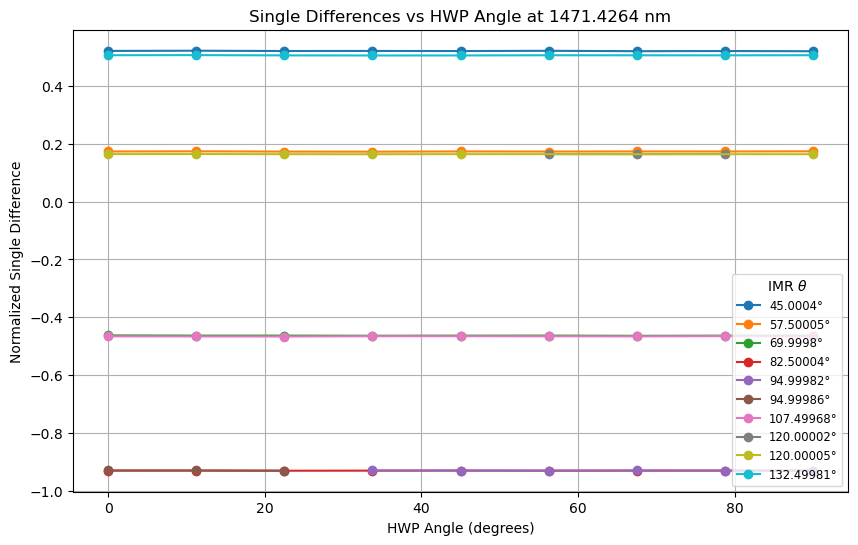

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization/plots/diffvshwp_bin7.png


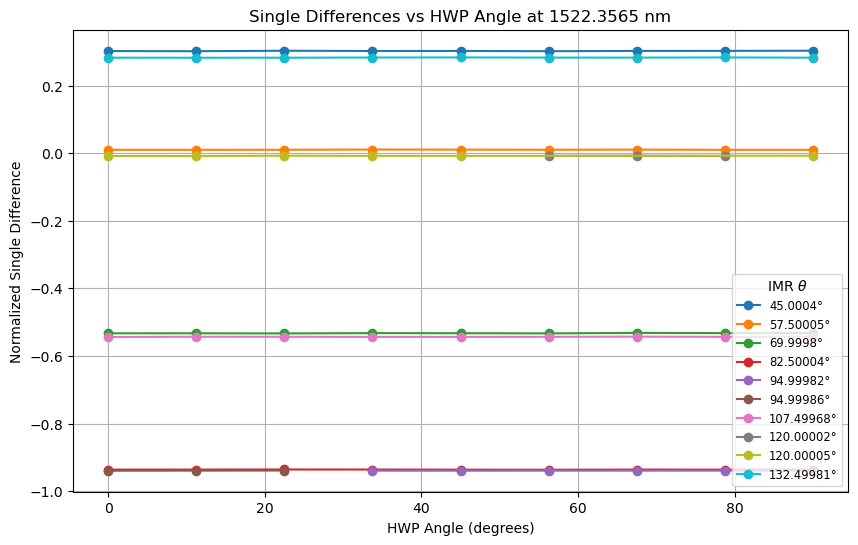

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization/plots/diffvshwp_bin8.png


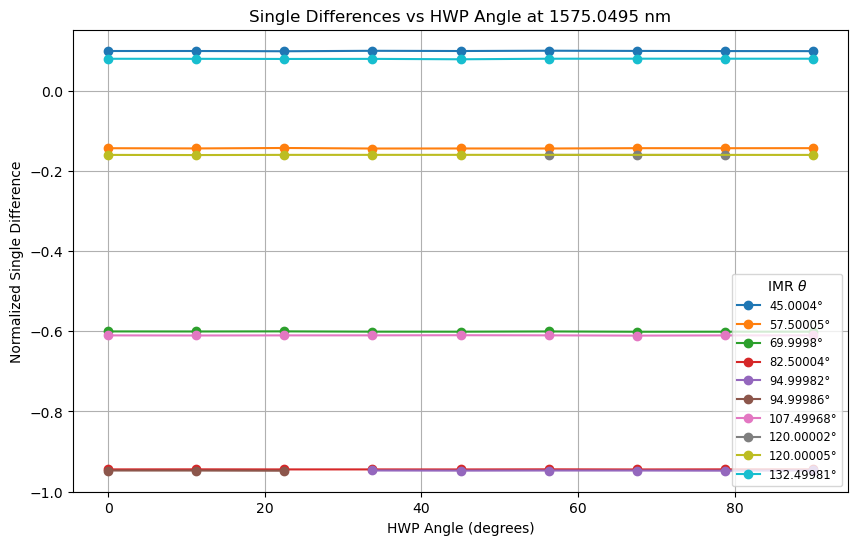

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization/plots/diffvshwp_bin9.png


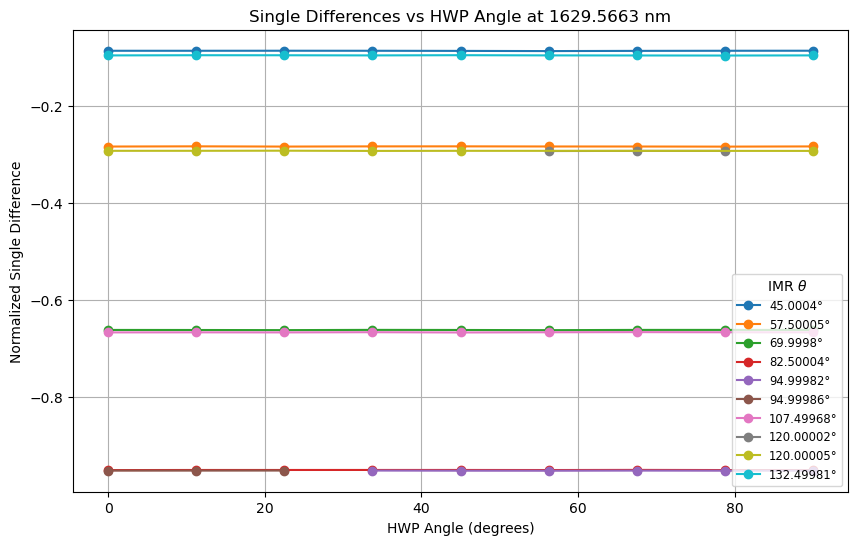

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization/plots/diffvshwp_bin10.png


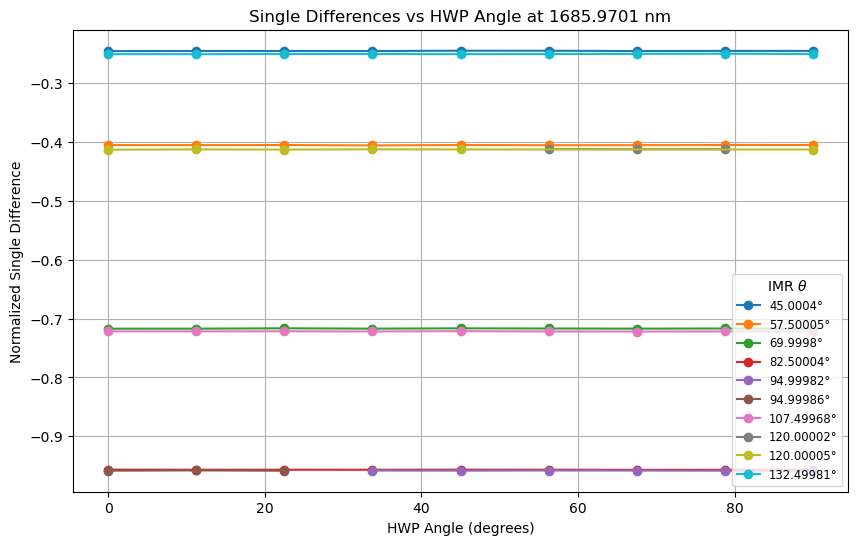

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization/plots/diffvshwp_bin11.png


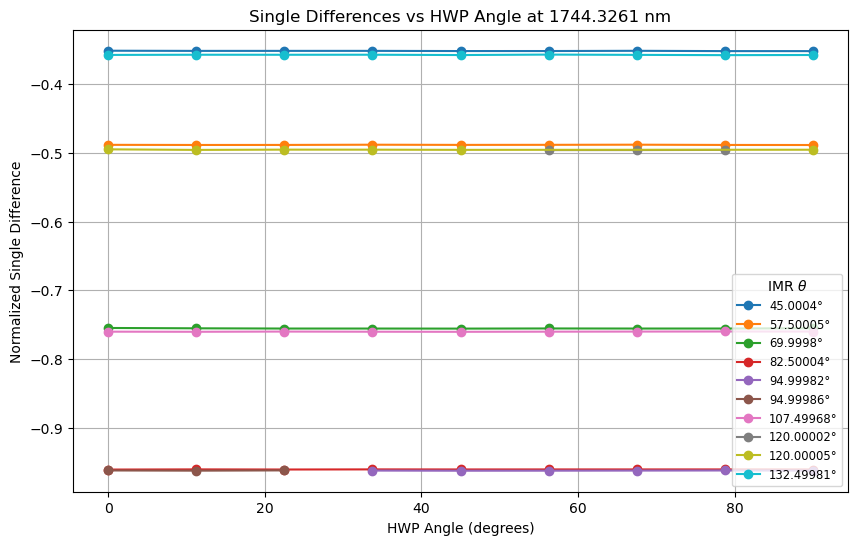

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization/plots/diffvshwp_bin12.png


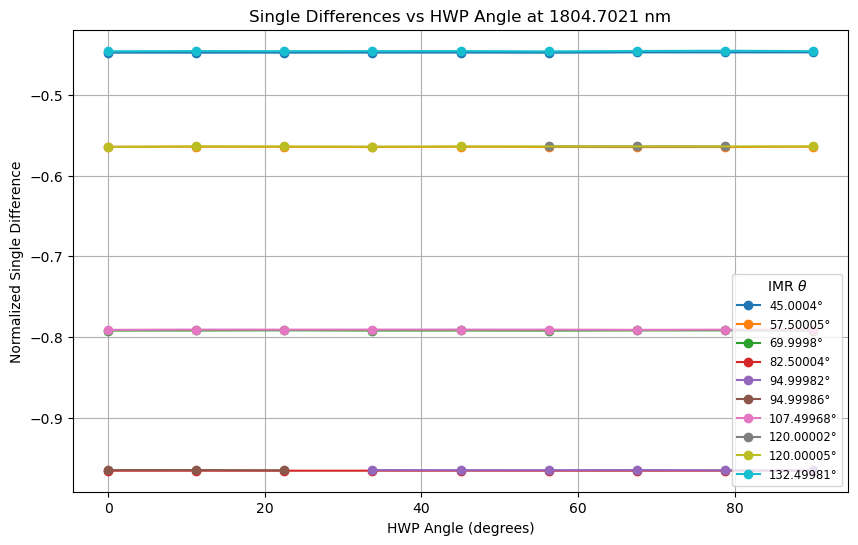

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization/plots/diffvshwp_bin13.png


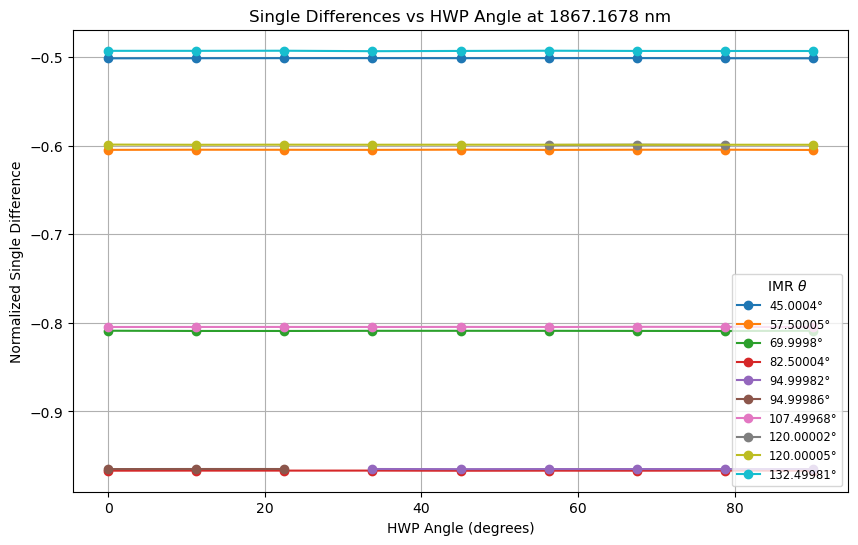

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization/plots/diffvshwp_bin14.png


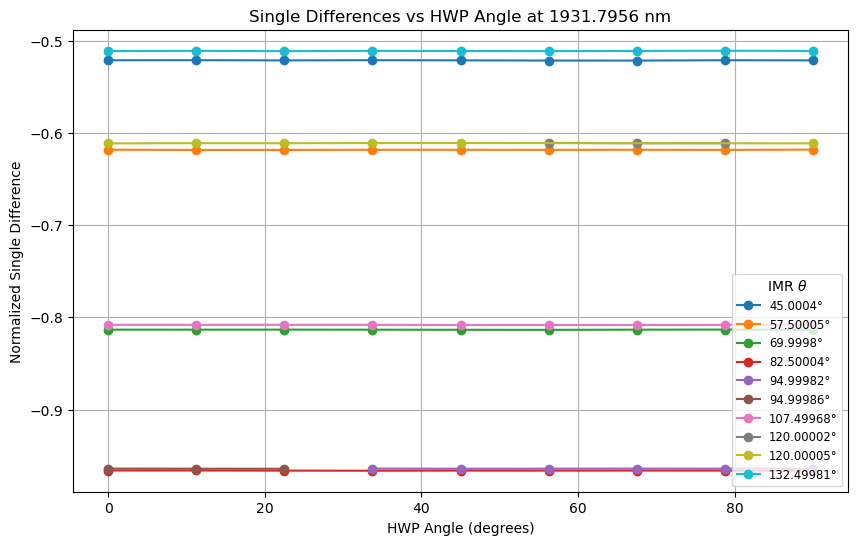

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization/plots/diffvshwp_bin15.png


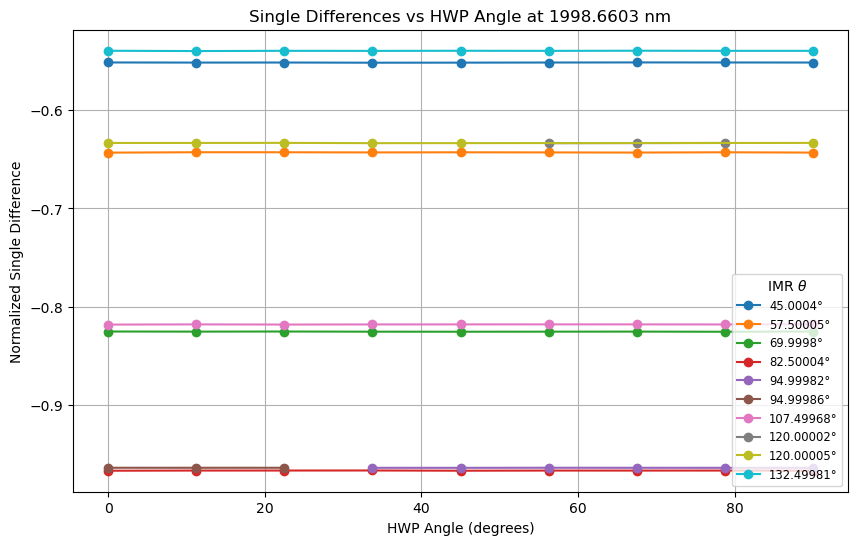

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization/plots/diffvshwp_bin16.png


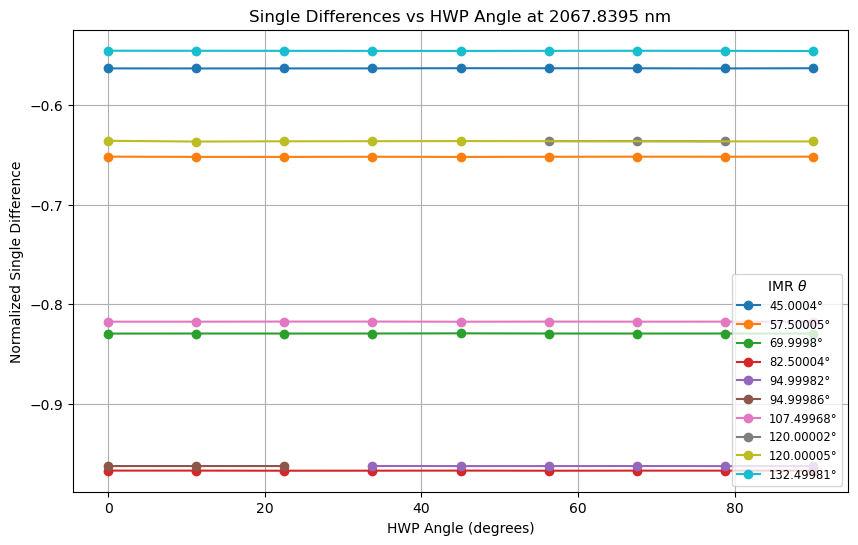

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization/plots/diffvshwp_bin17.png


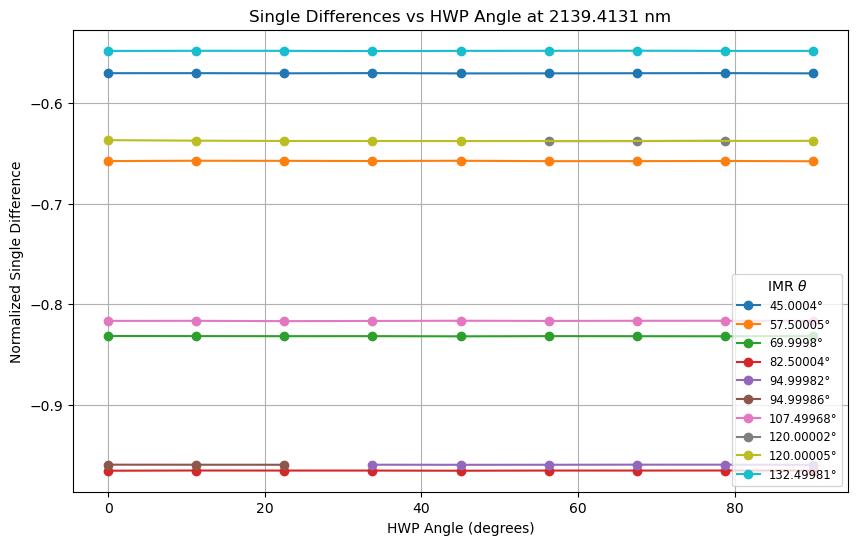

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization/plots/diffvshwp_bin18.png


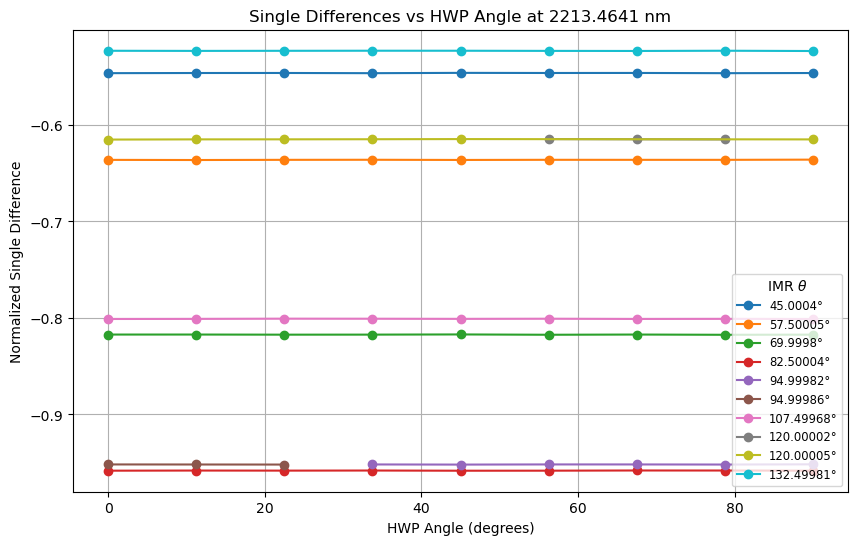

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization/plots/diffvshwp_bin19.png


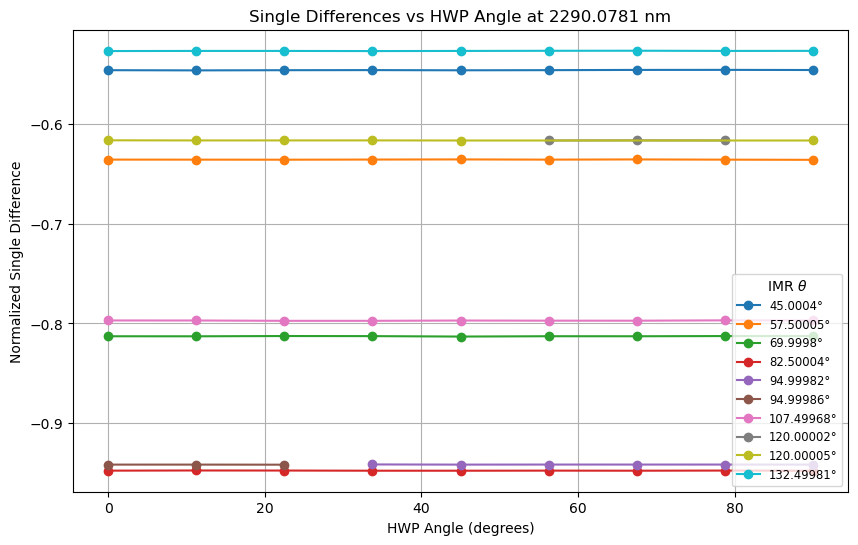

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization/plots/diffvshwp_bin20.png


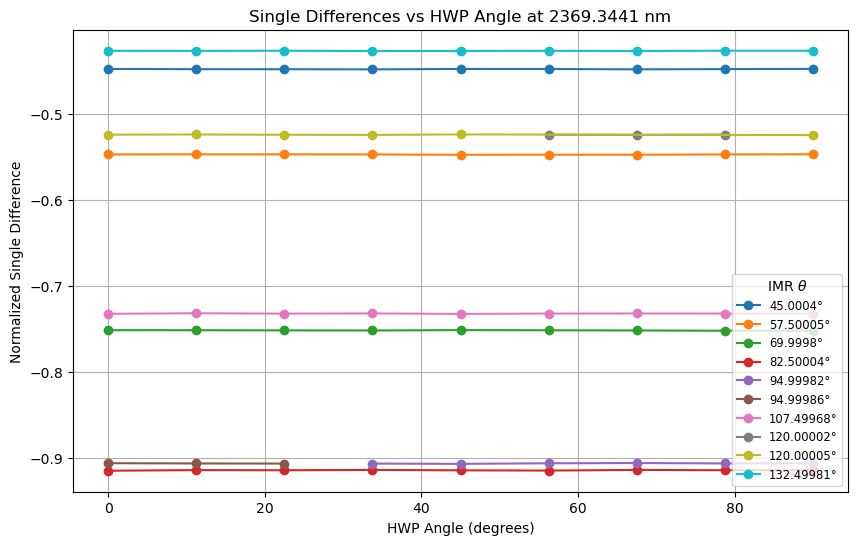

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization/plots/diffvshwp_bin21.png


In [96]:
for bin in range(0,22):
    plot_single_differences(f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization/csvs/charis_cube_info_bin{bin}_fixed.csv',f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization/plots/diffvshwp_bin{bin}.png')


In [113]:
def quick_data_all_bins(cube_directory_path, raw_directory_path, csv_directory, plot_directory):
    """Plot norm single differences as a function of the HWP angle 
    for each derotator angle and write a CSV containing headers "D_IMRANG" , "RET-ANG1" , 
    "norm_single_diff", and "wavelength_bin". Perform this for all 21 wavelength bins.
    
    Parameters:
    -----------
    cube_directory_path : str or Path
        Path to the directory containing CHARIS fits cubes.
        
    raw_directory_path : str or Path
        Path to the directory containing the matching raw CHARIS FITS files.

    csv_directory : str or Path
        Directory where the output csv files will be created.

    plot_directory : str or Path
        Directory where the output plots will be created.
        
    Returns:
    --------
    None
    """
    # check if cube_directory_path and raw_directory_path are valid paths

    cube_directory_path = Path(cube_directory_path)
    raw_directory_path = Path(raw_directory_path)
    
    if not cube_directory_path.is_dir():
        raise NotADirectoryError(f"Directory not found: {cube_directory_path}")
    if not raw_directory_path.is_dir():
        raise NotADirectoryError(f"Raw directory does not exist: {raw_directory_path}")
    if not csv_directory.is_dir():
        raise NotADirectoryError(f"CSV directory does not exist: {csv_directory}")
    if not plot_directory.is_dir():
        raise NotADirectoryError(f"Plot directory does not exist: {plot_directory}")
    # iterate over all wavelength bins

    for bin in range(0, 22):

        # write csv file for each bin

        csv_file_path = Path(csv_directory) / f'charis_cube_info_bin{bin}.csv'
        write_fits_info_to_csv(
            cube_directory_path=cube_directory_path,
            raw_cube_path=raw_directory_path,
            output_csv_path=csv_file_path,
            wavelength_bin=bin
        )

        # plot single differences for each bin

        plot_save_path = Path(plot_directory) / f'diffvshwp_bin{bin}.png'
        plot_single_differences(csv_file_path, plot_save_path)
    
    

CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/csv/charis_cube_info_bin0.csv


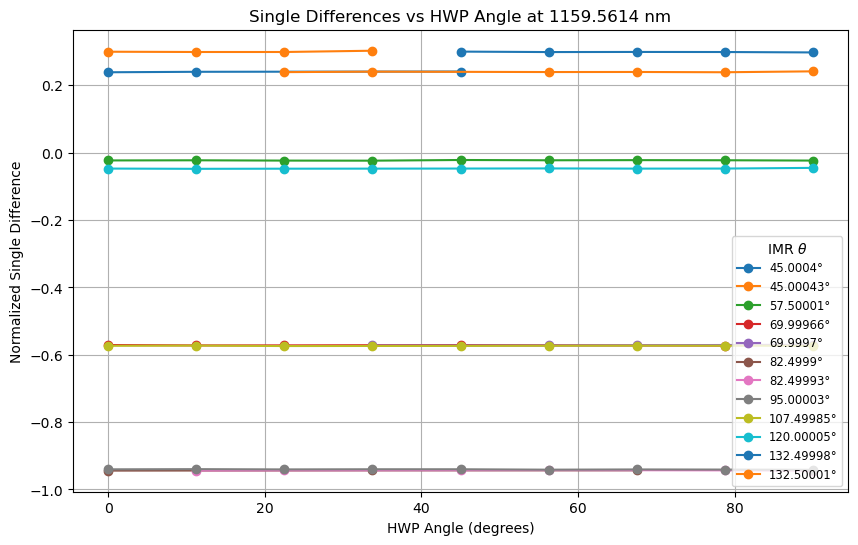

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/plots/diffvshwp_bin0.png
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/csv/charis_cube_info_bin1.csv


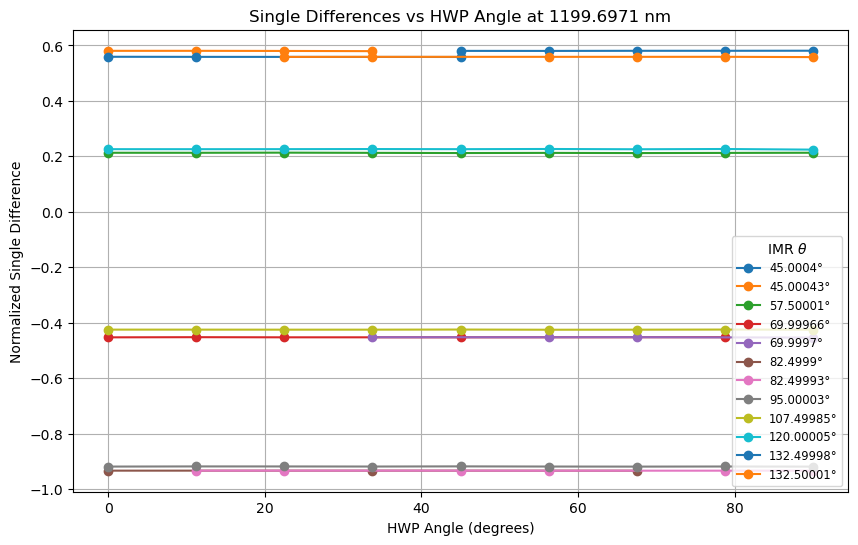

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/plots/diffvshwp_bin1.png
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/csv/charis_cube_info_bin2.csv


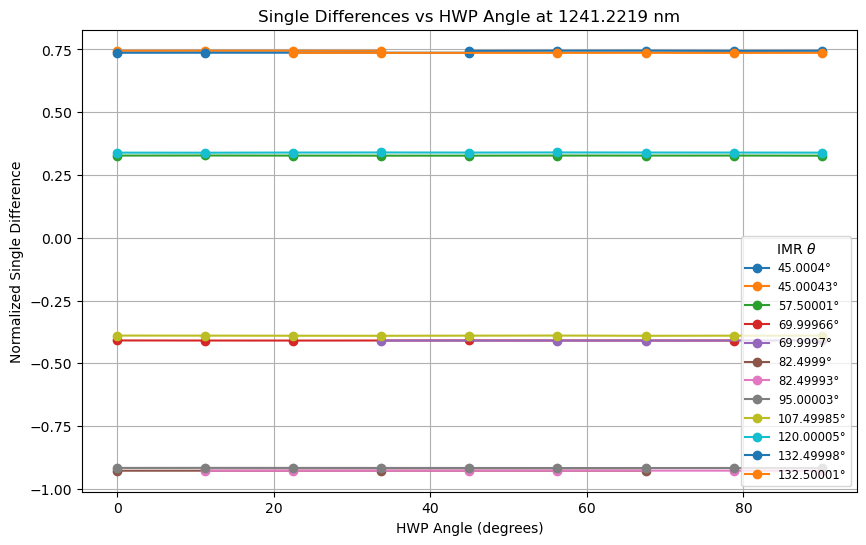

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/plots/diffvshwp_bin2.png
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/csv/charis_cube_info_bin3.csv


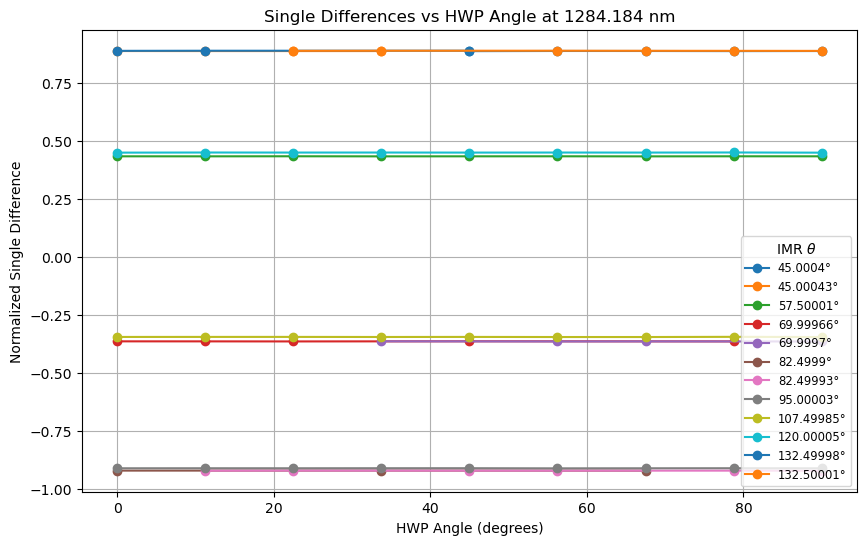

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/plots/diffvshwp_bin3.png
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/csv/charis_cube_info_bin4.csv


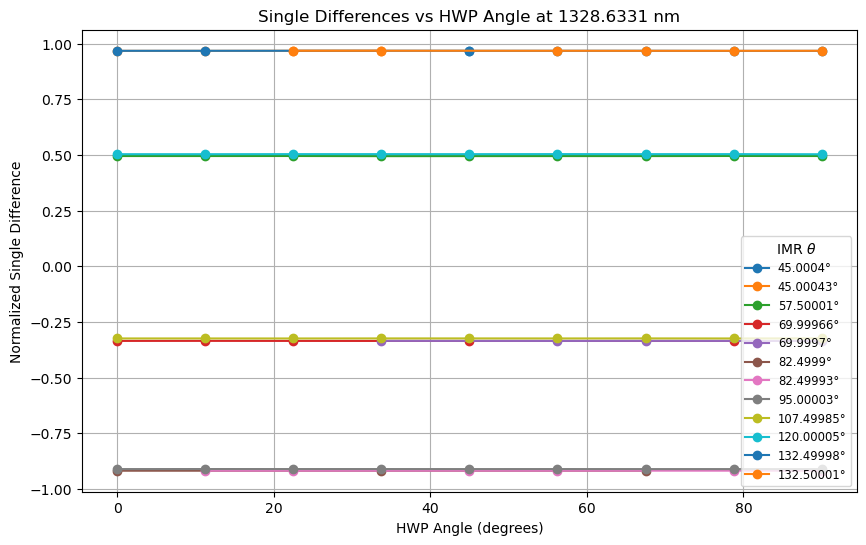

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/plots/diffvshwp_bin4.png
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/csv/charis_cube_info_bin5.csv


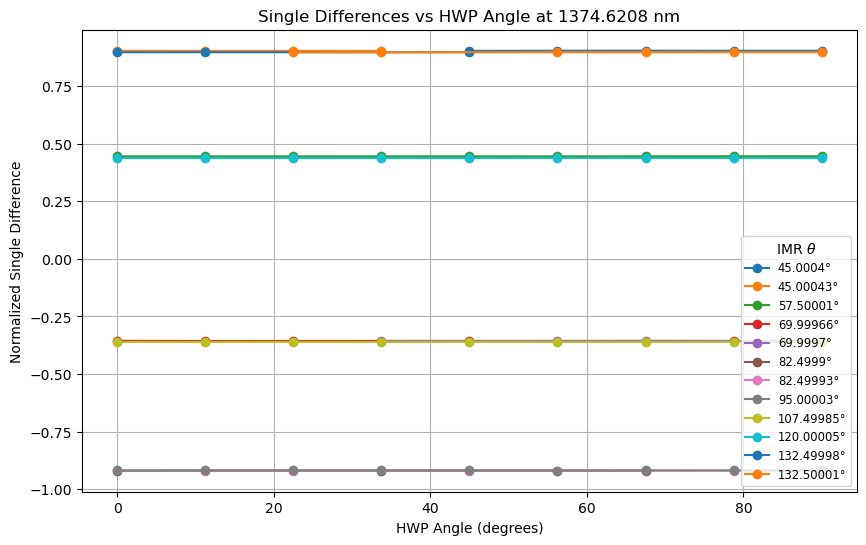

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/plots/diffvshwp_bin5.png
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/csv/charis_cube_info_bin6.csv


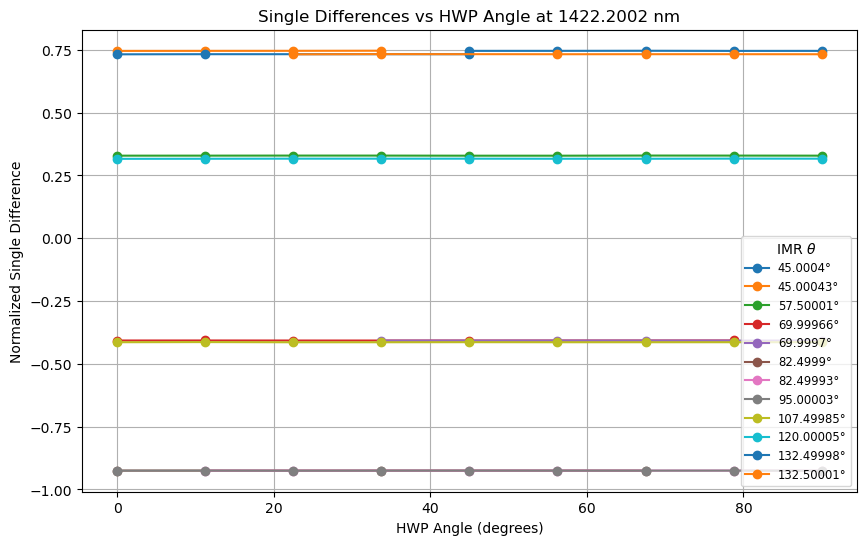

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/plots/diffvshwp_bin6.png
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/csv/charis_cube_info_bin7.csv


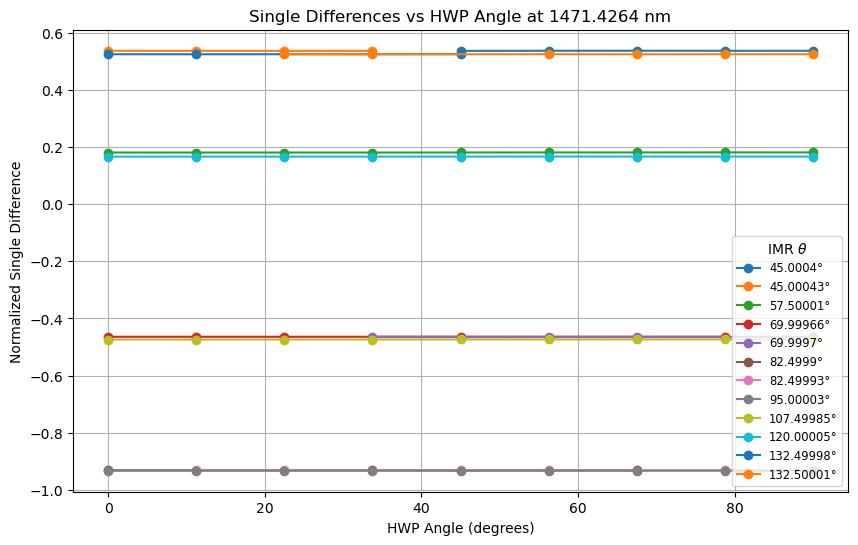

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/plots/diffvshwp_bin7.png
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/csv/charis_cube_info_bin8.csv


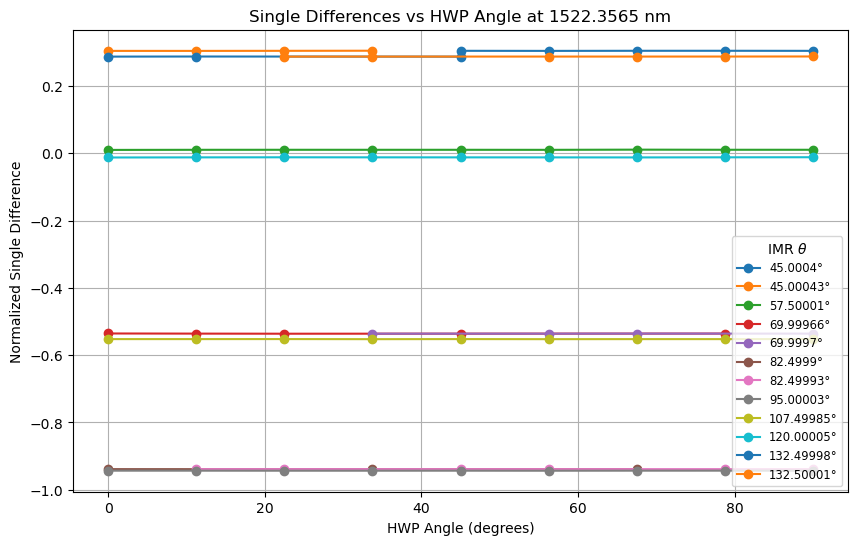

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/plots/diffvshwp_bin8.png
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/csv/charis_cube_info_bin9.csv


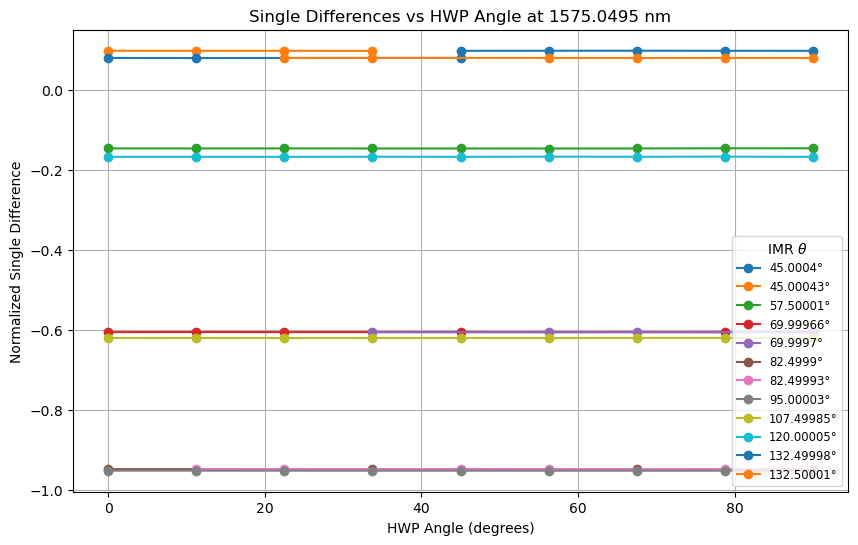

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/plots/diffvshwp_bin9.png
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/csv/charis_cube_info_bin10.csv


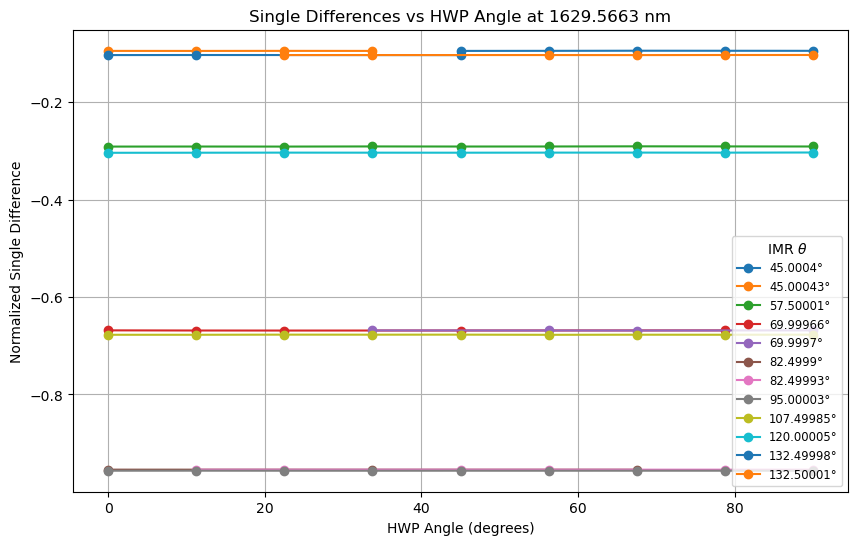

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/plots/diffvshwp_bin10.png
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/csv/charis_cube_info_bin11.csv


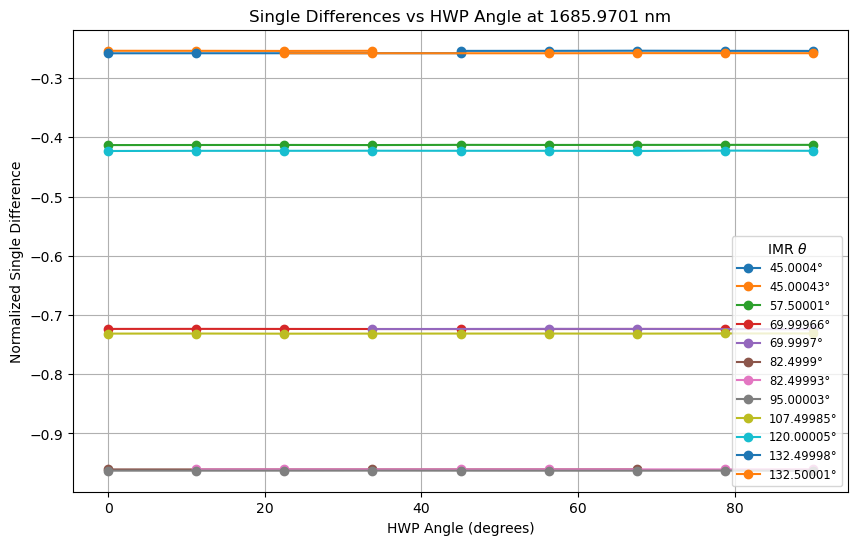

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/plots/diffvshwp_bin11.png
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/csv/charis_cube_info_bin12.csv


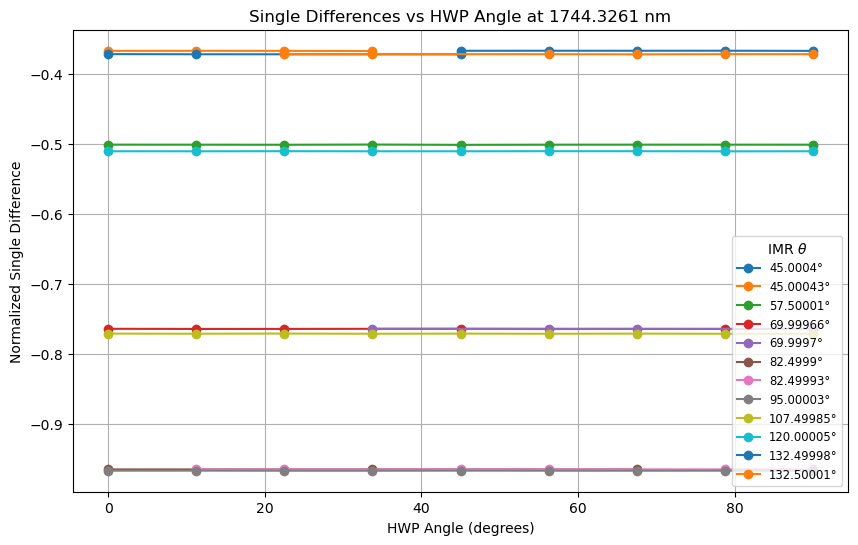

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/plots/diffvshwp_bin12.png
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/csv/charis_cube_info_bin13.csv


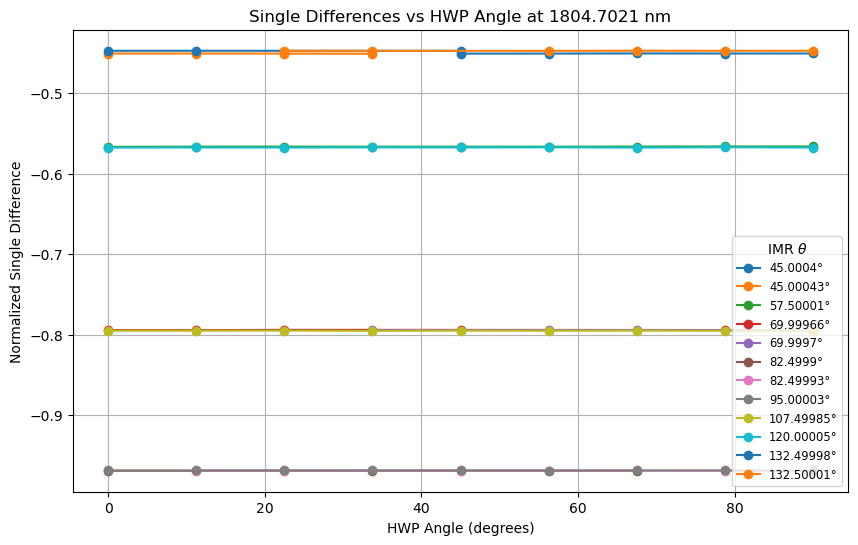

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/plots/diffvshwp_bin13.png
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/csv/charis_cube_info_bin14.csv


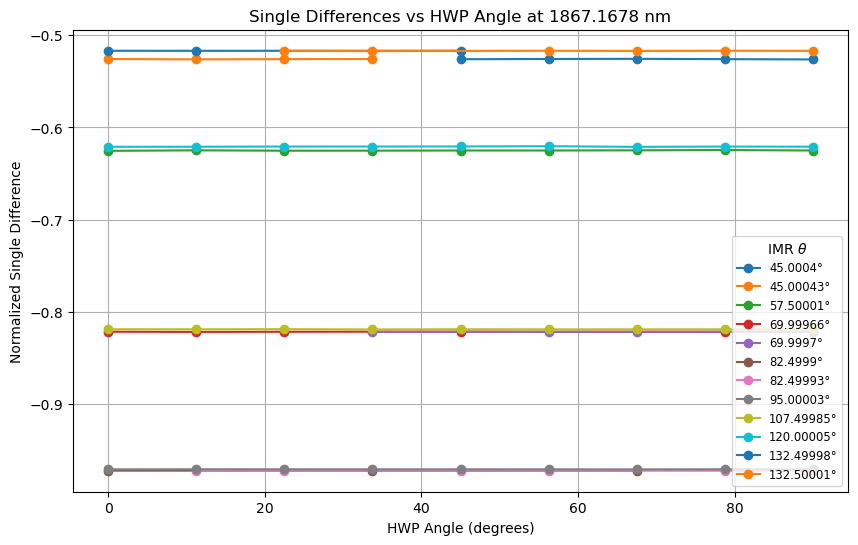

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/plots/diffvshwp_bin14.png
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/csv/charis_cube_info_bin15.csv


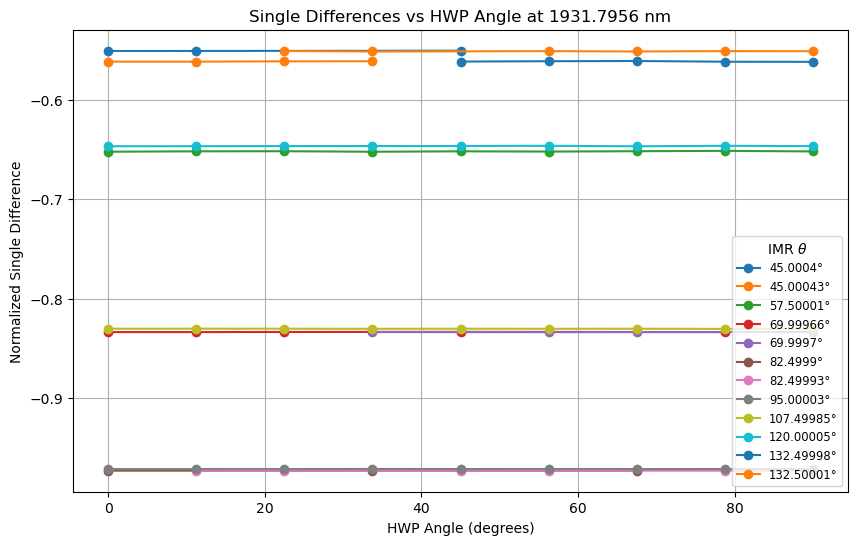

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/plots/diffvshwp_bin15.png
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/csv/charis_cube_info_bin16.csv


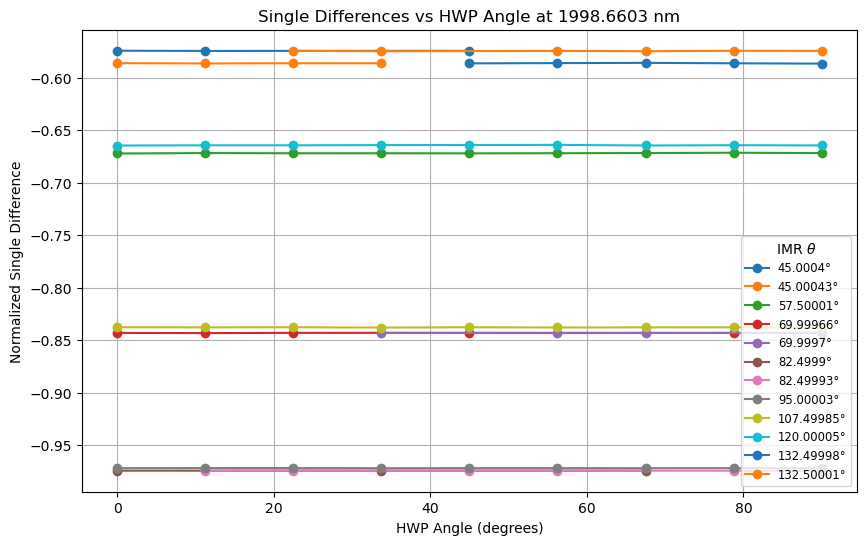

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/plots/diffvshwp_bin16.png
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/csv/charis_cube_info_bin17.csv


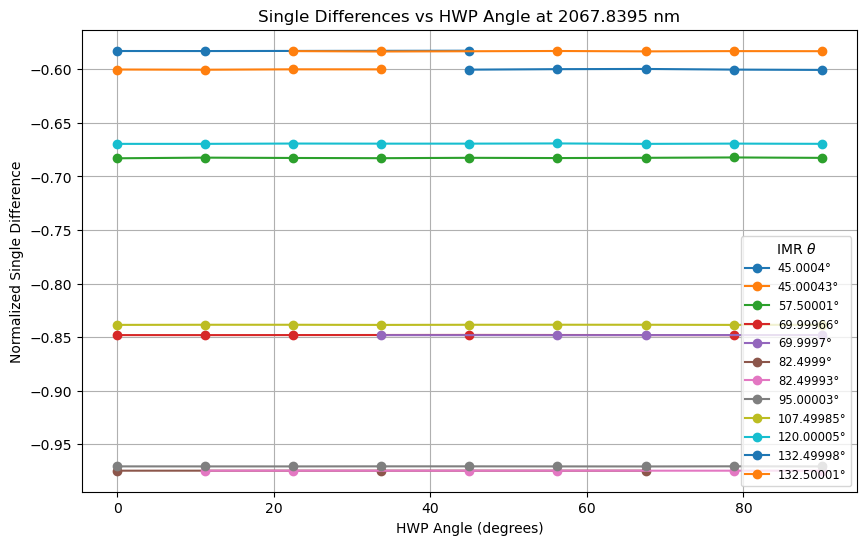

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/plots/diffvshwp_bin17.png
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/csv/charis_cube_info_bin18.csv


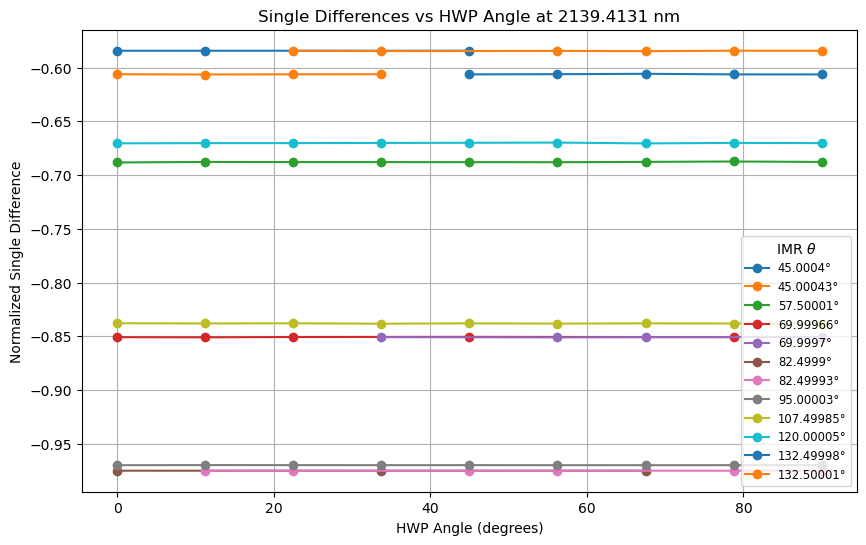

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/plots/diffvshwp_bin18.png
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/csv/charis_cube_info_bin19.csv


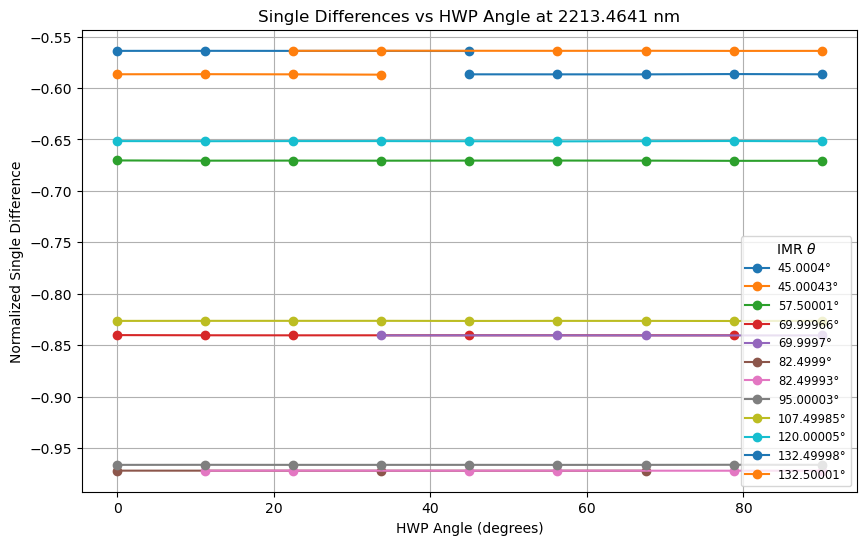

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/plots/diffvshwp_bin19.png
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/csv/charis_cube_info_bin20.csv


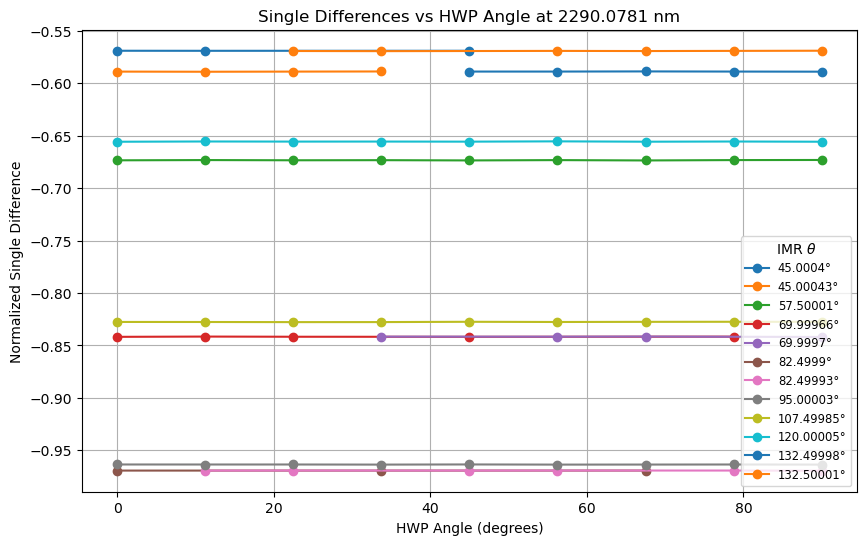

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/plots/diffvshwp_bin20.png
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/csv/charis_cube_info_bin21.csv


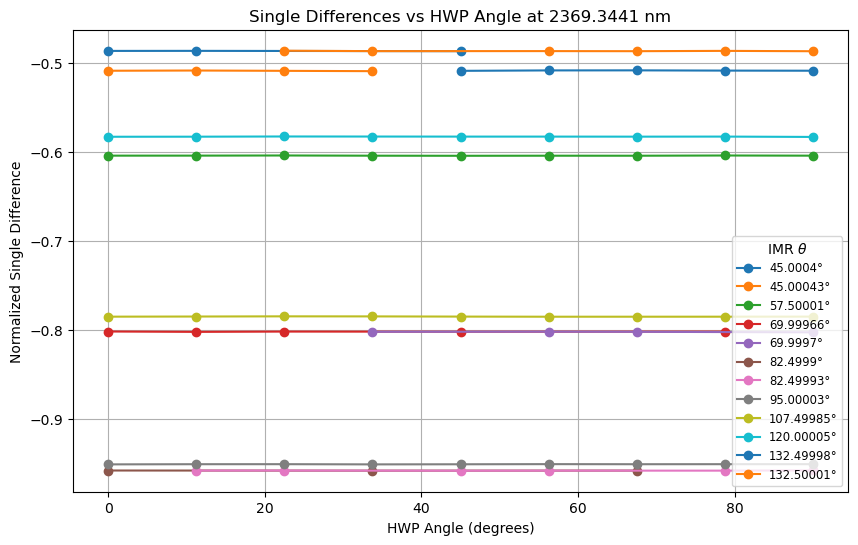

Plot saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/plots/diffvshwp_bin21.png


In [116]:
# perform on miles's data

quick_data_all_bins(
    cube_directory_path='/Users/thomasmcintosh/Desktop/CHARIS-REU/Cubes_2/cubes',
    raw_directory_path='/Users/thomasmcintosh/Desktop/CHARIS-REU/Raw_2/internal-cal',
    csv_directory=Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/csv'),
    plot_directory=Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_Visualization_2/plots')
)

In [120]:
# check single sum function for errors

sumtest, difftest = single_sum_and_diff('/Users/thomasmcintosh/Desktop/CHARIS-REU/Cubes_2/cubes/CRSA00162889_cube.fits', 8)
print(f"Single sum: {sumtest}, Normalized single difference: {difftest}")

# matches with csv output

# visually compared csv output to plots - matches

Single sum: 84895955.69364548, Normalized single difference: 0.3043997508570308
